# Les 03

## Inleiding

Dit is de werkcollege-oefening bij Les 03 van het vak *Advanced Datamining* (BFVH4DMN2). Bestudeer eerst de syllabus behorende bij deze les. Op BlackBoard kun je naast dit iPython/Jupyter notebook een tweetal Python-bestanden vinden. Sla deze op in dezelfde folder als dit notebook. Het verdient aanbeveling om voor elke les een aparte folder aan te maken.

- **template.py** bevat een opzet voor een module met object-georiënteerde implementaties van neurale netwerk algoritmen. Het doel van deze oefening is om deze code aan te vullen en uit te werken tot een correct werkend model. Open dit bestand in een code-editor naar keuze en sla het op als **model.py**. Vergeet niet om tijdens het uitwerken van deze oefening je aanpassingen in de editor telkens op te slaan voordat je de code in dit notebook uitvoert!

- **data.py** bevat een aantal functies die helpen bij het genereren en het visualiseren van de gebruikte datasets. Deze functies hoeven maar één keer ingelezen te worden en hoef je niet te wijzigen om deze opdracht correct uit te kunnen voeren.

Laten we dus beginnen om deze functies te importeren, samen met wat initialisatie-code: plaats de cursor in de cel hieronder en druk op Shift+Enter.

In [1]:
%matplotlib inline
from importlib import reload

import template, data

## Het multi-layer perceptron

In deze les gaan we de eerder gemaakt neuronen in parallelle en seriële lagen aan elkaar koppelen om krachtigere algoritmen mee te construeren. We gaan meerdere typen lagen definiëren, waaronder lagen met neuronen die lineaire combinaties van attributen maken en daar activatiefuncties op toepassen, en andere neurale lagen die een loss-functie toepassen om de kwaliteit van de fit te berekenen. Deze opzet leent zich voor *inheritance*. In het model is een parent-class `Layer()` voorgedefineerd waarvan we diverse child-classes zullen afleiden, zoals `FullLayer()` voor een fully-connected layer of `LossLayer()` voor de berekening van de loss-functie. Deze parent-class houdt een variabele `next` bij die verwijst naar de volgende neurale laag (of `None` als het de laatste laag betreft), vergelijkbaar met een *linked list* datastructuur. De code van de parent-class hoef je deze les in principe niet te veranderen.

Begin weer met het implementeren van de instantiatie-methode `__init__()` voor zowel de `FullLayer()` en `LossLayer()` child-classes. De reeds voorgedefinieerde `__str__()` methoden geven een idee welke variabelen deze in elk geval zullen moeten bevatten. Merk op dat eerst de `__init__()` methode van de parent-class door beide child-classes aangeroepen dient te worden.

Houd rekening met de volgende verschillen ten opzichte van de vorige les:

- Neurale lagen kunnen naast meerdere invoeren ook meer dan één uitvoer hebben. De uitvoer van een laag zal dus eveneens de vorm van een vector of `list()` moeten hebben. Ook de biases en gewichten moeten meervoudig worden uitgevoerd. Wel maken alle neuronen in een laag gebruik van dezelfde activatie-functie.

- Het is niet zinvol om alle neuronen binnen een laag met dezelfde modelparameters te initialiseren. De biases worden gewoonlijk wel allemaal op nul gesteld, maar de gewichten worden geïnitialiseerd met een random waarde tussen $\pm\sqrt{\frac{6}{N_{\text{in}}+N_{\text{uit}}}}$, met $N_{\text{in}}$ en $N_{\text{uit}}$ gelijk aan het aantal inkomende en uitgaande verbindingen van een neuron.

De parent-class implementeert reeds een methode `append()` die een extra laag toevoegt aan een bestaand netwerk. Deze wordt geërfd door de child-classes. Hoewel de child-classes op dit moment nog weinig functionele code bevatten kan de werking wel worden geïllustreerd. De onderstaande code zou een neuraal netwerk moeten weergeven dat uit drie lagen bestaat, met correct geinitialiseerde modelparameters en eigenschappen.

Overigens werkt ook de weggecommentarieerde concatenatie met het plus-teken doordat de parent-class een `__add__()` methode ondersteunt die op haar beurt weer gebruik maakt van `append()`. Probeer beide methoden uit.

In [2]:
reload(template)

my_network = template.FullLayer(2, 3)        # Een neurale laag met 2 invoeren en 3 uitvoeren
my_network.append(template.FullLayer(3, 1))  # Een neurale laag met 3 invoeren en 1 uitvoer
my_network.append(template.LossLayer())      # Een loss-laag
# Of: my_network = model.FullLayer(2, 3) + model.FullLayer(3, 1) + model.LossLayer()
print(my_network)

FullLayer():
  - biases = 0.0
  - weights = [0.73, -0.409]
  - act_func = identity_act_func
  - next = \
FullLayer():
  - biases = 0.0
  - weights = [0.161, 0.28, -0.605]
  - act_func = identity_act_func
  - next = \
LossLayer():
  - loss_func = quadratic_loss_func


We implementeren eerst weer de `predict()` en `loss()` methoden. Je mag ervan uitgaan dat de laatste laag in het netwerk *altijd* een `LossLayer()` zal zijn. Deze moet immers de kwaliteit van de uiteindelijk gemaakte voorspelling beoordelen met behulp van de loss-functie, want deze uitkomst is hetgeen je wil optimaliseren. De daaraan voorafgaande lagen bestaan voorlopig allemaal uit een `FullLayer()`.

De predictie kan recursief geïmplementeerd worden, waarbij elke fully-connected neurale laag de volgende laag aanroept totdat de recursie beëindigd wordt door de laatste loss-layer. Er gelden dan de volgende uitgangspunten:

- Een loss-laag krijgt invoer binnen. Die invoer komt al uit de laatste fully-connected neurale laag, dus dat vormt reeds de voorspelling $\boldsymbol{\hat{y}}$ van het model. De loss-laag kan dus rechtstreeks de invoer retourneren als voorspelling.

- Een fully-connected neurale laag krijgt invoer binnen, berekent hieruit (middels lineaire combinatie en activatiefunctie) diens uitvoer, en geeft die door aan de volgende laag. De volgende laag gaat hier vervolgens de predictie mee vervolgen. De voorspelling die die volgende laag rapporteert wordt tenslotte ook door de fully-connected neurale laag geretourneerd als eigen voorspelling.

Implementeer op deze manier de `predict()` methoden voor de beide child-classes. Je kan hierbij vermoedelijk putten uit je uitwerkingen van de vorige les.

De onderstaande code test je predictie voor één neurale laag met één neuron dat twee invoeren heeft en de identiteitsfunctie als activatiefunctie. (Dit is gewoon een lineair regressie model met twee attributen.) Omdat de bias en gewichten op nul worden gesteld zou de predictie altijd gelijk aan $\boldsymbol{\hat{y}}=\left[0\right]$ moeten zijn; de predictie is nu een vector met lengte één omdat er in dit geval één output is.

In [3]:
reload(template)

my_network = template.FullLayer(2, 1, act_func=template.identity_act_func)
my_network.weights = [[0.0, 0.0]]
my_network.biases = [0.0]
my_network.append(template.LossLayer(loss_func=template.quadratic_loss_func))
x = [2.71828, 3.14159]   # Kies twee willekeurige getallen x1 en x2 als invoer
print('Prediction =', my_network.predict(x))

Prediction = 0.0


Voor de loss geldt ongeveer hetzelfde. De fully-connected neural layer kan wederom zijn uitvoer berekenen uit diens invoer en doorgeven naar de volgende laag, en dan de gerapporteerde loss retourneren. De loss-layer is dit keer verantwoordelijk voor het bepalen voor de loss. Hiertoe dienen door de gebruiker natuurlijk niet alleen de attributen te worden gegeven, maar ook de gewenste uitkomst. Omdat er nu meerdere uitvoeren kunnen zijn is de voorspelling een vector en dient de loss-layer de loss van alle elementen in die vector afzonderlijk te bepalen en op te tellen: $l=\sum_{m}L\left(\hat{y}_{m};y_{m}\right)$.

Implementeer de `loss()` methoden voor de beide child-classes. In het lineaire regressie model van zojuist dient de uitkomst $l=\frac{1}{2}$ op te leveren omdat de voorspelling $\hat{y}_1=0$ en de ware uitkomst $y_1=1$, met de kwadratische loss-functie $L\left(\hat{y}_{m};y_{m}\right)=\frac{1}{2}\left(y_m-\hat{y}_m\right)^{2}$.

In [4]:
reload(template)

my_network = template.FullLayer(2, 1, act_func=template.identity_act_func)
my_network.weights = [[0.0, 0.0]]
my_network.biases = [0.0]
my_network.append(template.LossLayer(loss_func=template.quadratic_loss_func))
x = [2.71828, 3.14159]   # Kies twee willekeurige getallen x1 en x2 als invoer
y = [1.0]                # Geef de gewenste uitkomst als een lijst met één element
print('Loss =', my_network.loss(x, y))

Loss = 1.0


## Het XOR-probleem

We gaan proberen diverse logische operatoren te modelleren. We zullen hier de conventie hanteren dat de waarde `False` gecodeerd wordt door een getalwaarde $y=-1$ en de waarde `True` door een getalwaarde $y=+1$. Dit stelt ons in staat de signum-functie te gebruiken.

We beginnen eenvoudig. De unaire *NOT*-operator keert de logische waarde om. Kortom, $x_1=-1$ (`False`) levert $y=+1$ (`True`, hieronder in blauw) en $x_1=+1$ (`True`) levert $y=-1$ (`False`, hieronder in rood). Een single-layer perceptron kan dit gedrag eenvoudig reproduceren, zoals in de onderstaande grafiek wordt getoond.

Merk op: in verband met het plotten in een 2D-grafiek is er een tweede attribuut $x_2$ toegevoegd dat steeds de waarde nul heeft; dit speelt verder geen rol.

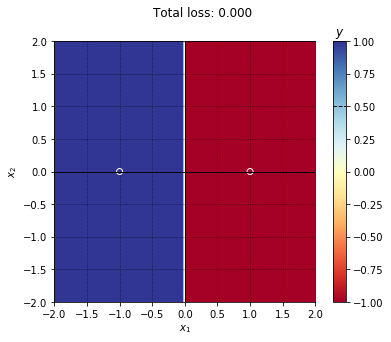

In [5]:
reload(template)

xs, ys = [[1.0, 0], [-1.0, 0]], [[-1.0], [+1.0]]
my_network = template.FullLayer(2, 1, act_func=template.signum_act_func)
my_network.biases = [0.0]          # Bias 0
my_network.weights = [[-1.0, 0]]   # Gewicht -1
my_network.append(template.LossLayer(loss_func=template.quadratic_loss_func))
data.scatter(xs, ys, model=my_network)

Gaan we verder met binaire operatoren. De *OR*-operator levert altijd een uitkomst $y=+1$ (`True`), behalve als diens beide inputs gelijk zijn aan $x_1=x_2=-1$ (`False`). Dit gedrag is ook te modelleren met een single-layer perceptron. Hieronder wordt een dergelijk model gemaakt, maar de bias en gewichten zijn niet juist ingesteld. Bedenk hoe de modelparameters gekozen moeten worden en ga na dat dit model correct werkt.

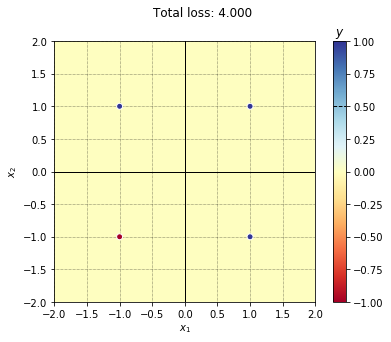

In [6]:
reload(template)

xs, ys = [[1.0, 1.0], [-1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]], [[+1.0], [+1.0], [+1.0], [-1.0]]
my_network = template.FullLayer(2, 1, act_func=template.signum_act_func)
my_network.biases = [0.0]           # Pas deze waarden aan
my_network.weights = [[0.0, 0.0]]   # Pas deze waarden aan
my_network.append(template.LossLayer(loss_func=template.quadratic_loss_func))
data.scatter(xs, ys, model=my_network)

De *AND*-operator levert alleen een uitkomst $y=+1$ (`True`) als diens beide inputs gelijk zijn aan $x_1=x_2=+1$ (`True`). Bepaal ook weer geschikte bias en gewichten voor dit geval.

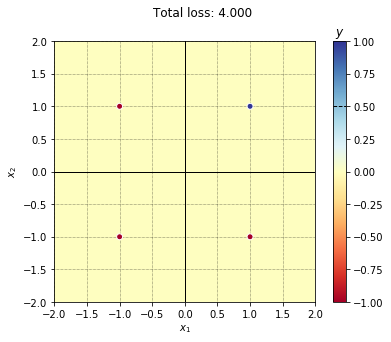

In [7]:
reload(template)

xs, ys = [[1.0, 1.0], [-1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]], [[+1.0], [-1.0], [-1.0], [-1.0]]
my_network = template.FullLayer(2, 1, act_func=template.signum_act_func)
my_network.biases = [0.0]           # Pas deze waarden aan
my_network.weights = [[0.0, 0.0]]   # Pas deze waarden aan
my_network.append(template.LossLayer(loss_func=template.quadratic_loss_func))
data.scatter(xs, ys, model=my_network)

De *XOR*-operator tenslotte levert $y=+1$ (`True`) als precies één van beide inputs gelijk is aan $+1$ (`True`) en de andere gelijk is aan $-1$ (`False`). Overtuig jezelf dat deze data niet met een single-layer perceptron te modelleren valt.

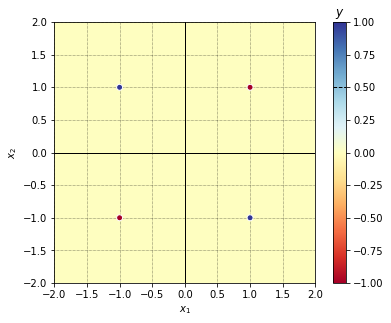

In [8]:
xs, ys = [[1.0, 1.0], [-1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]], [[-1.0], [+1.0], [+1.0], [-1.0]]
data.scatter(xs, ys)

De *XOR*-operatie kan wel worden gemodelleerd met een multi-layer perceptron. Je hebt hiervoor niet meer dan twee lagen nodig: een hidden layer met breedte twee en een niet-lineaire activatiefunctie (zoals de signum-functie), en een output layer met één neuron dat in principe toe kan met de lineaire identiteitsfunctie. De input layer wordt niet als een afzonderlijke laag gemodelleerd, maar wel voegen we een loss layer toe.

Hieronder wordt een dergelijk model opgezet. Pas dit model aan opdat het het *XOR*-probleem kan oplossen. Kies hiertoe in elk geval geschikte biases en gewichten; pas zonodig de activatiefuncties aan, of voeg desgewenst meer neuronen of neurale lagen toe.

Kun je meerdere verschillende modellen vinden die allemaal toch tot een juiste classificatie leiden?

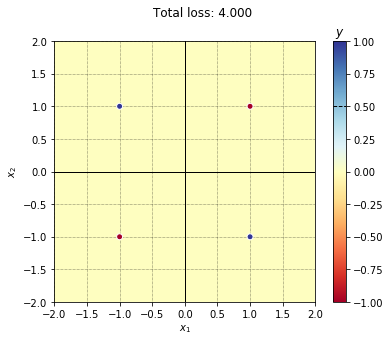

In [9]:
reload(template)

hidden_layer = template.FullLayer(2, 2, act_func=template.signum_act_func)
hidden_layer.biases = [0.0, 0.0]                  # Pas deze waarden aan
hidden_layer.weights = [[0.0, 0.0], [0.0, 0.0]]   # Pas deze waarden aan
output_layer = template.FullLayer(2, 1, act_func=template.identity_act_func)
output_layer.biases = [0.0]                       # Pas deze waarden aan
output_layer.weights = [[0.0, 0.0]]               # Pas deze waarden aan
loss_layer = template.LossLayer(loss_func=template.quadratic_loss_func)
my_network = hidden_layer + output_layer + loss_layer
data.scatter(xs, ys, model=my_network)

## Back-propagation

Om op een systematischere manier algemene oplossingen te vinden voor de modelparameters in een multi-layer perceptron zullen we opnieuw de optimalisatie-methode gebaseerd op gradiënt descent toepassen. Daartoe dienen we voor elke bias en elk gewicht te bepalen hoe de loss-functie verandert als de parameter gewijzigd wordt. Dat wil zeggen, we moeten $\frac{\partial l}{\partial b}$ en $\frac{\partial l}{\partial w_{i}}$ kennen voor alle $b$ en $w_i$.

We beginnen te kijken hoe de loss afhangt van de *input* van een layer. We zullen terugwerken van de loss layer richting de input layer. Voor de loss layer kan de afgeleide van de loss naar diens invoer $\frac{\partial l}{\partial \hat{y}_m}$ numeriek worden bepaald door de functie `derivative()` toe te passen op de loss-functie $L$.

We breiden de definitie van de `train()` functie uit de vorige les uit zodat deze ook de gradiënt van de loss als return-value geeft. Begin met de implementatie van de `train()` functie voor de loss layer. Deze heeft geen modelparameters en hoeft zelf dus niet getraind te worden, maar dient nu wel de gradiëntvector $\boldsymbol{\nabla_{\hat{y}}}l$ te retourneren. Deze code komt er ongeveer als volgt uit te zien:

```
def train(self, x, y, alpha=0):
    input_gradient = [...]
    return input_gradient
```

Merk op: de train-functie ontvangt evengoed een parameter `alpha` om compatibel te zijn met de andere neurale lagen, maar gebruikt deze learning rate zelf niet.

De onderstaande code simuleert een loss layer die een vector $\boldsymbol{\hat{y}}=\left[0,0,1,0 \right]$ ontvangt (een one-hot encoding van klasse #3) en vergelijkt met de gewenste uitkomst $\boldsymbol{y}=\left[0,1,0,0 \right]$ (een one-hot encoding van klasse #2). Ga na dat voor een kwadratische loss-functie de loss dan gelijk is aan $l=1$ en de gradiënt $\boldsymbol{\nabla_{\hat{y}}}l=\left[0,-1,+1,0 \right]$.

In [10]:
reload(template)

y_hat = [0.0, 0.0, 1.0, 0.0]
y = [0.0, 1.0, 0.0, 0.0]
loss_layer = template.LossLayer(loss_func=template.quadratic_loss_func)
print('Prediction =', loss_layer.predict(y_hat))
print('Loss =', loss_layer.loss(y_hat, y))
print('Gradient =', loss_layer.train(y_hat, y, alpha=0))

[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
Prediction = [0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 1.0, 0.0]


TypeError: unsupported operand type(s) for -: 'float' and 'list'

We gaan verder met de fully-connected layer. In de Syllabus vind je de back-propagation formules die vertellen hoe je, gegeven de gradiënt van de loss naar de output van de layer, eerst de gradiënt van de loss naar de pre-activatiewaarde kan berekenen, en daaruit de gradiënt van de loss naar de input van de layer kan bepalen. Dit behelst het vermenigvuldigen met de helling van de activatiefunctie, en het sommeren van producten met gewichten.

We berekenen de pre- en post-activaties van de neuronen via feed-forward evaluatie, en de gradiënten via back-propagation. We passen de modelparameters van de laag nog even niet aan. Je krijgt dan iets als dit:

```
def train(self, x, y, alpha=0)
    pre_activation = [...]
    post_activation = [...]
    post_gradient = self.next.train(...)
    pre_gradient = [...]
    input_gradient = [...]
    return input_gradient
```

De onderstaande code simuleert een output layer die een instance ontvangt met attributen $\boldsymbol{x}=\left[1,-1 \right]$ en hieruit een predictie afleidt gelijk aan $\boldsymbol{\hat{y}}=\left[0,0,1,0 \right]$. Deze wordt door de loss layer vergeleken met de gewenste uitkomst $\boldsymbol{y}=\left[0,1,0,0 \right]$ (zie hierboven). Dit zou moeten opleveren voor de loss $l=1$ en de gradiënt $\boldsymbol{\nabla_{x}}l=\left[1,0 \right]$. Verifieer je uitkomsten.

In [12]:
reload(template)

x = [1.0, -1.0]
y = [0.0, 1.0, 0.0, 0.0]
output_layer = template.FullLayer(2, 4, act_func=template.identity_act_func)
output_layer.weights = [[1.0, 1.0], [0.0, 0.0], [1.0, 0.0], [0.0, 1.0]]
output_layer.biases = [0.0, 0.0, 0.0, 1.0]
output_layer.append(template.LossLayer(loss_func=template.quadratic_loss_func))
print('Prediction =', output_layer.predict(x))
print('Loss =', output_layer.loss(x, y))
print('Gradient =', output_layer.train(x, y, alpha=0))

Prediction = -1.0
Loss = 7.0


AttributeError: 'FullLayer' object has no attribute 'output'

We kennen nu de gradiënten van de loss naar de pre- en post-activaties van alle neurale lagen. De laatste stap is hieruit de gradiënten van de loss naar de gewichten af te leiden.

- De gradiënt naar een gewicht $w_{ki}$ kan worden geschreven als $\frac{\partial l}{\partial w_{ki}} = \frac{\partial l}{\partial a_k}\cdot\frac{\partial a_k}{\partial w_{ki}}$. Hierin is $\frac{\partial l}{\partial a_k}$ reeds berekend, want die zit in de `pre_gradient` uit de code hierboven. De afgeleide $\frac{\partial a_k}{\partial w_{ki}}=x_i$, net als in de vorige les voor het single-layer perceptron.

- De gradiënt naar de bias $b$ kan eveneens worden geschreven als $\frac{\partial l}{\partial b} = \frac{\partial l}{\partial a_k}\cdot\frac{\partial a_k}{\partial b}$. Hierin is opnieuw $\frac{\partial l}{\partial a_k}$ bekend, en is $\frac{\partial a_k}{\partial b}=1$.

Kortom, zodra de gradiënten via back-propagation zijn doorgerekend, kunnen de afgeleiden van de loss naar de bias en gewichten hiermee ook worden bepaald. Hierop wordt tenslotte stochastic gradient descent volgens $\boldsymbol{w}\leftarrow\boldsymbol{w}-\alpha\cdot\boldsymbol{\nabla_{w}}l$ toegepast.

Implementeer deze functionaliteit in de `train()` functie. Voeg tenslotte ook de `fit()` functie weer toe die een aantal epochs traint; deze code zul je waarschijnlijk identiek uit de vorige les kunnen overnemen. Hieronder wordt dit multi-layer perceptron model gebruikt om het *XOR*-probleem te fitten. Wordt er elke keer als je deze code draait een goede oplossing gevonden met de perfecte loss $l=0$?

In [ ]:
reload(template)

hidden = template.FullLayer(2, 2, act_func=template.tanh_act_func)
output = template.FullLayer(2, 1, act_func=template.identity_act_func)
loss = template.LossLayer(loss_func=template.quadratic_loss_func)
my_network = hidden + output + loss
my_network.fit(xs, ys, alpha=0.3)
data.scatter(xs, ys, model=my_network)  
print(my_network)

We kunnen ook eens proberen met één model zowel de *AND*- als de *OR*-operator te modelleren door een netwerk te definiëren met twee uitvoeren. Hoewel we voor dit probleem strict genomen geen hidden layer nodig hebben aangezien het single-layer perceptron deze operaties kon reproduceren, kiezen we er hieronder voor om een extra hidden layer met breedte vier te gebruiken. Wordt elke keer dat je het model draait een loss $l=0$ bereikt, en vindt het steeds nagenoeg dezelfde oplossing wanneer het convergeert?

In [ ]:
reload(template)

xs, ys = [[1.0, 1.0], [-1.0, 1.0], [1.0, -1.0], [-1.0, -1.0]], [[+1.0, +1.0], [-1.0, +1.0], [-1.0, +1.0], [-1.0, -1.0]]
hidden = template.FullLayer(2, 4, act_func=template.tanh_act_func)
output = template.FullLayer(4, 2, act_func=template.identity_act_func)
loss = template.LossLayer(loss_func=template.quadratic_loss_func)
my_network = hidden + output + loss
my_network.fit(xs, ys, alpha=0.3)
data.scatter(xs, ys, model=my_network)  
print(my_network)

**Gefeliciteerd!** Je hebt nu een basaal neuraal netwerk algoritme geïmplementeerd.

Experimenteer weer hoe het algoritme zich gedraagt. Bijvoorbeeld:

- Hoe ziet de oplossing van het *XOR*-probleem eruit als je de softsign-activatiefunctie gebruikt? Convergeert dit model meer of minder robuust naar een optimum?

- Wat gebeurt er met de vorm van de oplossing als je de hidden layer breder maakt? Of wat wanneer je een extra hidden layer toevoegt?

- Blijft het mogelijk om een exacte fit te vinden als je extra datapunten toevoegt (bv. met $x_1$ en/of $x_2$ gelijk aan nul, en zelf gekozen gewenste uitkomsten)?